# 1.1 Example: Polynomial Curve Fitting

In [ ]:
import os
import functools
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

We generate a dataset using $sin(2\pi x)$ function but also add some observation noise to reflect the true world !

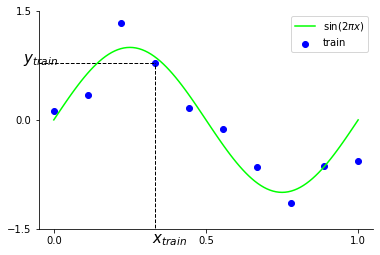

In [ ]:
N = 10
SEED = 1234
SCALE = 0.25

np.random.seed(SEED)

def true_fun(x):
    return np.sin(2 * np.pi * x)

def generate_noisy_data(x, scale=SCALE):
    y = true_fun(x) + np.random.normal(scale=scale, size=x.shape)
    return y

x_plot = np.arange(0, 1.01, 0.01)
y_plot = true_fun(x_plot)

# points with noise, will act as train data
x_train = np.linspace(0, 1, N)
y_train = generate_noisy_data(x_train)

plt.plot(x_plot, y_plot, color='lime', label="$\sin(2\pi x)$")
plt.scatter(x_train, y_train, marker='o', color='blue', label="train")
plt.hlines(y=y_train[3], xmin=-2, xmax=x_train[3], linewidth=1, linestyle='--', color = 'k')
plt.vlines(x=x_train[3], ymin=-2, ymax=y_train[3], linewidth=1, linestyle='--', color = 'k')

plt.text(-0.1, y_train[3], "$y_{train}$", fontsize=15)
plt.text(x_train[3] - 0.01, -1.7, "$x_{train}$", fontsize=15)
plt.yticks( [-1.5, 0.0, 1.5] )
plt.xticks( [0.0, 0.5, 1.0] )
plt.xlim(-0.05, 1.05)
plt.ylim(-1.5, 1.5)
plt.legend();

We will now use different models of regression to determine the weights. These models will differ by the degree of polynomial so as a first step let's transform our features ($x_{train}$)

In [ ]:
def transform_features(X, m):
    """ Create a polynomial of specified degrees """
    return PolynomialFeatures(degree=m).fit_transform(X.reshape(-1, 1))

# examples of creating the polynomial features
features_m_0 = transform_features(x_train, m=0)
features_m_1 = transform_features(x_train, m=1)
features_m_3 = transform_features(x_train, m=3)
features_m_9 = transform_features(x_train, m=9)

In [ ]:
def multiple_regression_fit(features, y_train):
    A_t = features.T @ features
    weight_vector = np.linalg.solve(A_t, features.T @ y_train)
    return weight_vector

def multiple_regression_predict(features, weight_vector):
    return np.dot(features, weight_vector)

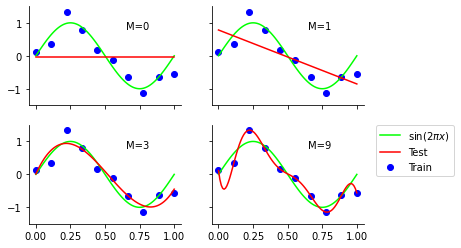

In [ ]:
# we will invoke above fit & predict methods in a loop for all
# the polynomials

# test data
# x that we used to draw out sin function will act as the test data

def regress(m, x, y):
    poly_train_features = transform_features(x, m=m)
    return multiple_regression_fit(poly_train_features, y)

def predict(m, x, weight_vector):
    poly_test_features = transform_features(x, m=m)
    return multiple_regression_predict(poly_test_features, weight_vector)

def regress_and_predict(m, x_train, y_train, x_test):
    weight_vector = regress(m, x_train, y_train)
    return predict(m, x_test, weight_vector)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

plt.xlim(-0.05, 1.05)
plt.ylim(-1.5, 1.5)

def plot(m, x, y_predict, ax):
    # true function
    ax.plot(x_plot, y_plot, color='lime', label="$\sin(2\pi x)$")

    # training data
    ax.scatter(x_train, y_train, marker='o', color='blue', label="Train")

    # Show the poly degree
    ax.text(0.65, 0.8, f"M={m}")

    # finally the predictions
    ax.plot(x, y_predict, color='red', label="Test")


x_test = np.linspace(0, 1, 100)
y_test = generate_noisy_data(x_test)

partial_rp = functools.partial(regress_and_predict,
                        x_train=x_train,
                        y_train=y_train,
                        x_test=x_test)

results = list(map(partial_rp, [0,1,3,9]))

plot(m=0, x=x_test, y_predict=results[0], ax=ax[0][0])
plot(m=1, x=x_test, y_predict=results[1], ax=ax[0][1])
plot(m=3, x=x_test, y_predict=results[2], ax=ax[1][0])
plot(m=9, x=x_test, y_predict=results[3], ax=ax[1][1])

plt.legend(bbox_to_anchor=(1.05, 1.05));

Notes -

* Red curve shows the fitted curve.
* M=0 fails to create the sin curve
* M=1 also failed
* M=3 seems to re-create the curve close to original function
* M=9 creates a curve that passes through all the training data but fails to approximate sin and is very wiggly. This is overfitting.

## Evaluating residual value of $E(w^*)$

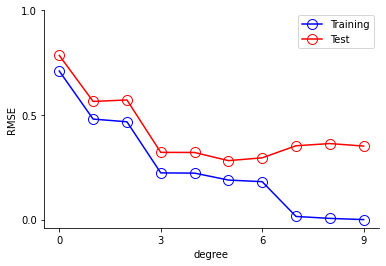

In [ ]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

# try polynomial of degrees from 0 to 10
M = range(0, 10)

weight_vectors = []
for m in M:
    w = regress(m=m, x=x_train, y=y_train)
    weight_vectors.append(w)

def compute_errors(x, y, m, weight_vector):
    y_predict = predict(m=m, x=x, weight_vector=weight_vector)
    return rmse(y_predict, y)

def accumate_errors(x, y):
    m_w = zip(M, weight_vectors)
    errors = []
    for (m, w) in m_w:
        errors.append(compute_errors(x, y, m, w))
    return errors

x_test = np.arange(0, 1.01, 0.01)
y_test = generate_noisy_data(x_test)

training_errors = accumate_errors(x_train, y_train)
test_errors = accumate_errors(x_test, y_test)

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.yticks( [0,0.5,1] )
plt.xticks( [0,3,6,9] )
plt.xlabel("degree")
plt.ylabel("RMSE");

Notes -

* For M = 9, the training set error goes to zero, for test set it shoots up
* A polynomial of higher degree contains the functions for lower so why this behavior ?

## Inspecting the weight vectors of various polynomials

In [ ]:
weight_vector_m_0 = regress(m=0, x=x_train, y=y_train)
weight_vector_m_1 = regress(m=1, x=x_train, y=y_train)
weight_vector_m_3 = regress(m=3, x=x_train, y=y_train)
weight_vector_m_9 = regress(m=9, x=x_train, y=y_train)

# makeing them same dimension so
# as display using a pandas frame
def pad_weight_vectors(weight_vector):
    while len(weight_vector) <= 9:
        weight_vector = np.append(weight_vector, 0.)
    return weight_vector

weight_vector_m_0 = pad_weight_vectors(weight_vector_m_0)
weight_vector_m_1 = pad_weight_vectors(weight_vector_m_1)
weight_vector_m_3 = pad_weight_vectors(weight_vector_m_3)
weight_vector_m_9 = pad_weight_vectors(weight_vector_m_9)

df = pd.DataFrame([weight_vector_m_0,weight_vector_m_1,weight_vector_m_3,weight_vector_m_9]).transpose()
df.columns = ['M=0', 'M=1', 'M=3', 'M=9']

df

,M=0,M=1,M=3,M=9
0,-0.035921,0.783019,0.011334,0.117859
1,0.000000,-1.637881,9.292162,-32.240315
2,0.000000,0.000000,-26.789442,552.780526
3,0.000000,0.000000,17.037287,-2730.404851
4,0.000000,0.000000,0.000000,4771.346668
5,0.000000,0.000000,0.000000,2008.069636
6,0.000000,0.000000,0.000000,-19321.678538
7,0.000000,0.000000,0.000000,28345.892698
8,0.000000,0.000000,0.000000,-17836.898852
9,0.000000,0.000000,0.000000,4242.454497


Notes -

* As M increases, the magnitude of weights is becoming larger
* In particular for M=9, the weights become very large +ive and -ive so that corresponding polynomial function matches the data point exactly

> Intuitively, what is happening is that the more flexible polynomials with larger values of M are becoming increasingly tuned to the random noise on the target values

## Increasing the datasize reduces overfitting

Here we use M=9 that resulted in overfitting but increase the training dataset size. We will try N=15 and N=100.

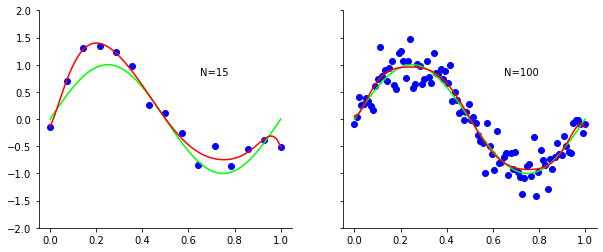

In [ ]:
def analyze_overfit(N, m=9):
    x_train = np.linspace(0, 1, N)
    y_train = generate_noisy_data(x_train)

    poly_train_features = transform_features(x_train, m=m)
    weight_vector = multiple_regression_fit(poly_train_features, y_train)

    return x_train, y_train, weight_vector

def regress_and_plot(x):

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    plt.xlim(-0.05, 1.05)
    plt.ylim(-2.0, 2.0)

    for i, n in enumerate([15, 100]):
        # get weight vector
        x_train, y_train, weight_vector = analyze_overfit(N=n)
        # make predictions
        poly_test_features = transform_features(x, m=9)
        y_predict = multiple_regression_predict(poly_test_features, weight_vector)

        # true function
        ax[i].plot(x_plot, y_plot, color='lime', label="$\sin(2\pi x)$")

        # training data
        ax[i].scatter(x_train, y_train, marker='o', color='blue', label="Train")

        # Show the poly degree
        ax[i].text(0.65, 0.8, f"N={n}")

        # finally the predictions
        ax[i].plot(x, y_predict, color='red', label="Test")

regress_and_plot(x=x_test)


From the above plots, it is evident that as we increased the data size to 100, we got rid of overfitting.

> One rough heuristic that is sometimes advocated is that the number of data points should be no less than some multiple (say 5 or 10) of the number of adaptive parameters in the model.

It is indeed a nuisance to have this delicate dance between number of parameters and dataset size. *Could Bayesian Inference help ?* Authors says - **Yes**

At the moment we restrict ourselves to current situation only. Here because we had a synthetic dataset we could increase the number of training samples at will but real world is differnt. So next question to ask is - *Could we reduce overfitting when we have less number of training examples ?*


## Regularization

We observed that the weights started to reach larger values for M=9; so one technique to circumvent is to add penalty term to the error function in order to discouragethe coefficients from reaching large values.

The new error function then takes the form

$$
E(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^N \{y(x_n, \mathbf{w}) - t_n\}^2 + \frac{\lambda}{2} ||\mathbf{w}||^2
$$

The $\lambda$ in the above equation controls the contribution of the regularization to the overall error. This is a hyper-parameter.

Above can be done in closed form.

This method is known by various other names as well.

In statistics, it is known as *shrinkage* since we are reducing the values of $\mathbf{w}$.

In machine learning, we call it *weight decay*.

In this particular case of quadratics weight decay, it is also called *Ridge Regression*

After some mathematical rigor, the closed form solution is -

$$ \beta^{ridge} = (X^T X + \lambda I)^{-1} X^T Y $$

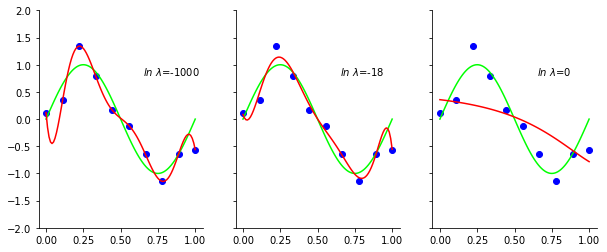

In [ ]:
# we will modify our multiple regression fit function
# to take this into account. Rest of the functions defined above
# should still be usable

def multiple_regression_ridge_fit(features, y_train, lamb):
    # Note - addition of second term for A_t
    A_t = features.T @ features + lamb * np.eye(features.shape[1], features.shape[1])
    weight_vector = np.linalg.solve(A_t, features.T @ y_train)
    return weight_vector

def regress_ridge(m, x, y, lamb):
    poly_train_features = transform_features(x, m=m)
    # get weights
    weight_vector = multiple_regression_ridge_fit(poly_train_features, y, lamb)
    return weight_vector

def regress_ridge_and_plot(x):

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10,4))

    plt.xlim(-0.05, 1.05)
    plt.ylim(-2.0, 2.0)

    for i, lamb in enumerate([-1000, -18, 0]):

        weight_vector_m_9_ridge = regress_ridge(m=9, x=x_train, y=y_train, lamb=np.exp(lamb))
        y_predict = predict(m=9, x=x, weight_vector=weight_vector_m_9_ridge)

        # true function
        ax[i].plot(x_plot, y_plot, color='lime', label="$\sin(2\pi x)$")

        # training data
        ax[i].scatter(x_train, y_train, marker='o', color='blue', label="Train")

        # Show the poly degree
        ax[i].text(0.65, 0.8, f"$ln \ \lambda$={lamb}")

        # finally the predictions
        ax[i].plot(x, y_predict, color='red', label="Test")

regress_ridge_and_plot(x=x_test)


$ln \ \lambda$ = -1000 corresponds to having no regualrizer. In the above plot, are shown the effect of 3 different regularizers. Clearly out of these 3, $ln \ \lambda$ = -18 seems to do the trick

In [ ]:
weight_vector_m_9_0 = regress_ridge(m=9, x=x_train, y=y_train, lamb=np.exp(-1000))
weight_vector_m_9_1 = regress_ridge(m=9, x=x_train, y=y_train, lamb=np.exp(-18))
weight_vector_m_9_2 = regress_ridge(m=9, x=x_train, y=y_train, lamb=np.exp(0))

weight_vector_m_9_0 = pad_weight_vectors(weight_vector_m_9_0)
weight_vector_m_9_1 = pad_weight_vectors(weight_vector_m_9_1)
weight_vector_m_9_2 = pad_weight_vectors(weight_vector_m_9_2)

df = pd.DataFrame([weight_vector_m_9_0,weight_vector_m_9_1,weight_vector_m_9_2]).transpose()
df.columns = ['ln lambda=-1000', 'ln lambda=-18', 'ln lambda=0', ]

df

,ln lambda=-1000,ln lambda=-18,ln lambda=0
0,0.117859,0.084455,0.357091
1,-32.240315,-8.198305,-0.332004
2,552.780526,185.185112,-0.403486
3,-2730.404851,-860.896418,-0.304300
4,4771.346668,1438.245443,-0.191590
5,2008.069636,-422.121842,-0.097300
6,-19321.678538,-1042.178572,-0.023986
7,28345.892698,231.682021,0.031876
8,-17836.898852,1113.582842,0.074296
9,4242.454497,-635.940161,0.106591


We see that, as the value of $\lambda$ increases, the typical magnitude of the coefficients gets smaller

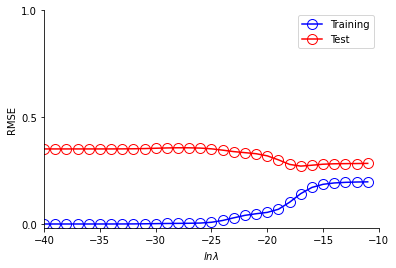

In [ ]:
lamb = range(-40, -10, 1)

train_errors = []
test_errors = []
for l in lamb:
    weight_vector_m_9_ridge = regress_ridge(m=9, x=x_train, y=y_train, lamb=np.exp(l))

    y_train_predict = predict(m=9, x=x_train, weight_vector=weight_vector_m_9_ridge)
    y_test_predict = predict(m=9, x=x_test, weight_vector=weight_vector_m_9_ridge)

    train_errors.append(rmse(y_train, y_train_predict))
    test_errors.append(rmse(y_test, y_test_predict))

plt.plot(lamb, train_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(lamb, test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.yticks( [0,0.5,1] )
plt.xlim((-40, -10))
plt.xlabel("$ln \lambda$")
plt.ylabel("RMSE");